<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

No information on wall, this very nature case which needs the exploration, try to see its relation of generalization to performance 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import Nets 
from Nets import * 

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

In [2]:
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)])
pregame.reset(set_agent=(2,2))
# rls_q = RLS(1)
# rls_sl = RLS(1)
# for i in range(1):
#     pregame.fulltrain(trials = 4)
    

In [3]:
game = ValueMaxGame(pregame.net, grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward =  [(0.5, 0.25), (0.5, 0.75)])
game.reset()
# game.experiment(rls_q, rls_sl, 20, epsilon = 0.5, lr = 1e-3, train_hidden = False, train_q = False) 

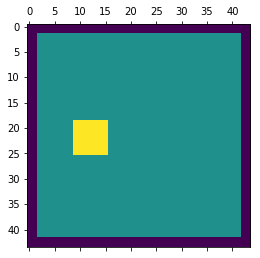

In [4]:
plt.matshow(game.grid.grid)
# plt.savefig('g16h3-map')

## Model Tranining 
Pretranining is done with fixed size 15,  training is between 10 to 15, test on 19 

Training from zero seems to be better because it will allow the agent to explore from new

In [5]:
for iters, noise in enumerate(3 * [0.0]):
    for trial in [212]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights2/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train = np.arange(10, 51, 10), size_test=[10, 50])


clear session data 49 6478848000
0 rewards (0.617624269005848, -0.5997408541541442)
clear session data 49 6526386176
1 rewards (0.6973489583333334, -0.7396449704142012)
clear session data 49 6678491136
2 rewards (0.9465767543859649, -0.6163461538461539)
clear session data 49 6493630464
3 rewards (0.9275413602941177, -0.5730171392000889)
clear session data 49 6493630464
4 rewards (0.9860359432234432, -0.6568047337278107)
clear session data 49 8532094976
5 rewards (0.927704730576441, -0.47802919281512435)
clear session data 49 8532389888
6 rewards (0.8290294117647059, -0.5517529487621287)
clear session data 49 8532393984
7 rewards (0.9173009868421053, -0.5396711336334743)
clear session data 49 8532393984
8 rewards (0.7181696428571429, -0.604176939513478)
clear session data 49 8532393984
9 rewards (0.9486108630952381, -0.6478388027177753)
clear session data 49 8532393984
10 rewards (0.9883537581699346, -0.6297035144824094)
clear session data 49 8532393984
11 rewards (0.8980575174148607, -

In [7]:
for iters, noise in enumerate(3 * [0.0]):
    for trial in [399]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights2/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train = np.arange(10, 51, 10), size_test=[10, 50])


clear session data 49 8498638848
0 rewards (0.5840880847953216, -0.6099328696494688)
clear session data 49 8498638848
1 rewards (0.755546256879945, -0.4224338022152576)
clear session data 49 8498638848
2 rewards (0.9792543859649123, -0.6522628950578631)
clear session data 49 8498638848
3 rewards (0.887046875, -0.5333442559255406)
clear session data 49 8498638848
4 rewards (0.7891720085470085, -0.5454695405722143)
clear session data 49 8498638848
5 rewards (0.8288521634615384, -0.3798038386599836)
clear session data 49 8498638848
6 rewards (0.7766673116615067, -0.39865585327961306)
clear session data 49 8498638848
7 rewards (0.8179600563909775, -0.5449907029481735)
clear session data 49 8498638848
8 rewards (0.7464732142857142, -0.3609467455621302)
clear session data 49 8498638848
9 rewards (0.9379093567251462, -0.5199849941944097)
clear session data 49 8498900992
10 rewards (0.9273080065359477, -0.560392030675942)
clear session data 49 8498900992
11 rewards (0.9142682748538011, -0.6451

In [3]:
for iters, noise in enumerate(3 * [0.0]):
    for trial in [0]: 
        Pretest =  PretrainTest(holes = 0, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial))
        weight_read = Pretest.weight
        weight_write = 'weights2/rnn_1515tanh512_checkpoint{}_{}'.format(trial, iters)
        rewards = Pretest.qlearn(weight_read,  weight_write, iterations = 20, noise = noise, size_train = np.arange(10, 51, 10), size_test=[10, 50])


clear session data 49 5386268672
0 rewards (0.26597407882687485, -0.6681614812177559)
clear session data 49 5199532032
1 rewards (0.1776813080495356, -0.7233334112263476)
clear session data 49 6193930240
2 rewards (0.29647600081699343, -0.4751468222907394)
clear session data 49 6193930240
3 rewards (0.3953331613347093, -0.5782788092641373)
clear session data 49 6193930240
4 rewards (0.5477220394736843, -0.6867059693699965)
clear session data 49 7708680192
5 rewards (0.7763047969187674, -0.6153846153846154)
clear session data 49 7708749824
6 rewards (0.705501177115583, -0.5393645640463175)
clear session data 49 7500447744
7 rewards (0.8417731338149295, -0.5081731468802997)
clear session data 49 7500447744
8 rewards (0.9381273881347412, -0.4718328187552017)
clear session data 49 8486064128
9 rewards (0.788828125, -0.5342671992920922)
clear session data 49 8486133760
10 rewards (0.7068774671052631, -0.3517047481215423)
clear session data 49 8486133760
11 rewards (0.5468958333333334, -0.44

## Model Test